## В этом мини-проекте протестируем несколько гипотез по данным о такси-компании, которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. 

Cформулируем и протестируем гипотезы, выделим группы водителей, которые наиболее подвержены "оттоку". \
На основе результатов сделаем выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import scikit_posthocs as sp

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
df = pd.read_csv(r"C:\Users\yarus\projects\data\churn.csv")

In [3]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


## Описание колонок:
city – город \
phone – основное устройство, которое использует водитель \
signup_date – дата регистрации аккаунта (YYYYMMDD) \
last_trip_date – дата последней поездки (YYYYMMDD) \
avg_dist – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации \
avg_rating_by_driver – средняя оценка поездок водителем \
vg_rating_of_driver – средняя оценка поездок водителя \
surge_pct – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд) \
avg_surge – средний множитель всплеска за все поездки этого водителя \
trips_in_first_30_days – количество поездок, которые совершил водитель в первые 30 дней после регистрации \
luxury_car_user – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль \
weekday_pct – процент поездок пользователя, совершенных в будние дни 

In [4]:
df.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
luxury_car_user              bool
weekday_pct               float64
dtype: object

Приведем значения в полях last_trip_date и signup_date к типу данных даты.

In [5]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)

In [6]:
df.signup_date = pd.to_datetime(df.signup_date)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   avg_dist                50000 non-null  float64       
 1   avg_rating_by_driver    49799 non-null  float64       
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   city                    50000 non-null  object        
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   signup_date             50000 non-null  datetime64[ns]
 8   surge_pct               50000 non-null  float64       
 9   trips_in_first_30_days  50000 non-null  int64         
 10  luxury_car_user         50000 non-null  bool          
 11  weekday_pct             50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

Добавим новое поле - количество дней с последней поездки до максимального значения даты последней поездки по всем записям.

In [8]:
df['days_since_last_trip'] = df.last_trip_date.max() - df.last_trip_date

In [9]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,days_since_last_trip
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,14 days
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,57 days
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,175 days
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,2 days
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,108 days


Приведем новое поле к типу данных - integer - дни.

In [10]:
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days

In [11]:
df['days_since_last_trip']

0         14
1         57
2        175
3          2
4        108
        ... 
49995     26
49996    157
49997     40
49998    167
49999     72
Name: days_since_last_trip, Length: 50000, dtype: int64

## Оценим, есть ли различия в размерах оттока клиентов в разных городах (churn, city)

В новом поле разделим записи по оттоку водителей, если количество дней более 30.

In [12]:
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')

In [13]:
df[['days_since_last_trip', 'churn']]

,days_since_last_trip,churn
0,14,not_churn
1,57,churn
2,175,churn
3,2,not_churn
4,108,churn
...,...,...
49995,26,not_churn
49996,157,churn
49997,40,churn
49998,167,churn


Посмотрим на соотношение показателя оттока.

In [14]:
df.churn.value_counts(normalize=True).mul(100).round(2)

churn        62.39
not_churn    37.61
Name: churn, dtype: float64

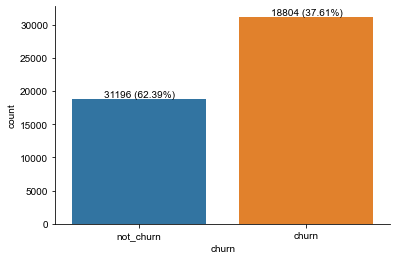

In [15]:
ax = sns.countplot('churn', data=df)
abs_values = df['churn'].value_counts()
rel_values = df['churn'].value_counts(normalize=True).mul(100)
lbls = [f'{p[0]} ({p[1]:.2f}%)' for p in zip(abs_values, rel_values)]
ax.bar_label(container=ax.containers[0], labels=lbls)
sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")
sns.despine()

In [16]:
df.city.value_counts(normalize=True).mul(100).round(2)

Winterfell        46.67
Astapor           33.07
King's Landing    20.26
Name: city, dtype: float64

Посмотрим есть ли различия в размерах оттока клиентов в разных городах (churn, city).

In [17]:
tab = pd.crosstab(df.churn, df.city)

In [18]:
tab

city,Astapor,King's Landing,Winterfell
churn,,,
churn,12306,3767,15123
not_churn,4228,6363,8213


Проведем тест независимости хи-квадрат.

In [19]:
stat, p, dof, expected  = stats.chi2_contingency(tab)
p

0.0

Есть основания отклонить нулевую гипотезу, т.к. значение p-value < 0. 05. Можно утверждать, что есть взаимосвязь в показателях оттока водителей от города.

## Оценим, есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов (city, trips_in_first_30_days)

Посмотрим на показатель количества поездок, которые совершил водитель в первые 30 дней после регистрации.

In [20]:
df.trips_in_first_30_days.describe()

count    50000.000000
mean         2.278200
std          3.792684
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        125.000000
Name: trips_in_first_30_days, dtype: float64

Проверим распределение на нормальность.

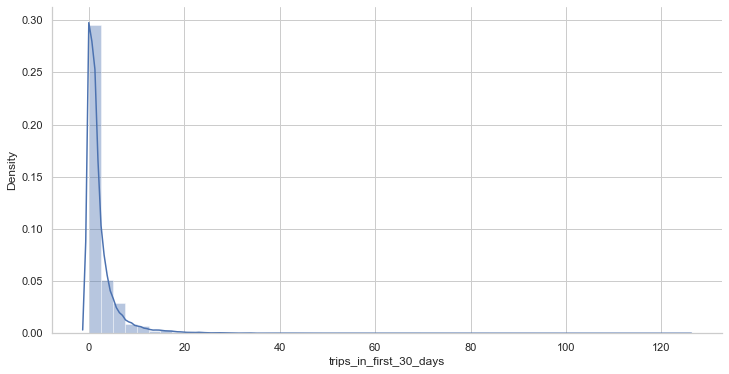

In [21]:
sns.distplot(df.trips_in_first_30_days)
sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")
sns.despine()

Выделим показатель в отдельные серии, в зависимости от города.

In [22]:
Astapor = df[df.city == 'Astapor'].trips_in_first_30_days
KingsLanding = df[df.city == "King's Landing"].trips_in_first_30_days
Winterfell = df[df.city == 'Winterfell'].trips_in_first_30_days

Проведем тесты Шапиро-Уилка - тесты на нормальность. Он используется для определения того, соответствует ли выборка нормальному распределению.

In [23]:
stats.shapiro(Astapor.sample(1000, random_state=17)).pvalue

4.203895392974451e-45

In [24]:
stats.shapiro(KingsLanding.sample(1000, random_state=17)).pvalue

1.6829594556541053e-42

In [25]:
stats.shapiro(Winterfell.sample(1000, random_state=17)).pvalue

7.006492321624085e-45

Все значения p-value < 0.05. Т.е. распределения не являются нормальными, поэтому используем непараметрический аналог ANOVA – критерий Краскела-Уоллиса.

In [26]:
stats.kruskal(Astapor, KingsLanding, Winterfell)

KruskalResult(statistic=221.32105325317454, pvalue=8.724567791938856e-49)

Обнаружены статистически значимые различия (p-value < 0.05).

## Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)

In [27]:
churn = df[df.churn == 'churn'].trips_in_first_30_days

In [28]:
not_churn = df[df.churn == 'not_churn'].trips_in_first_30_days

In [29]:
churn.describe()

count    31196.000000
mean         1.658482
std          2.654222
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         73.000000
Name: trips_in_first_30_days, dtype: float64

In [30]:
not_churn.describe()

count    18804.000000
mean         3.306318
std          4.986743
min          0.000000
25%          0.000000
50%          2.000000
75%          4.000000
max        125.000000
Name: trips_in_first_30_days, dtype: float64

Посмотрим на распределения показателей в группах с оттоком и без.

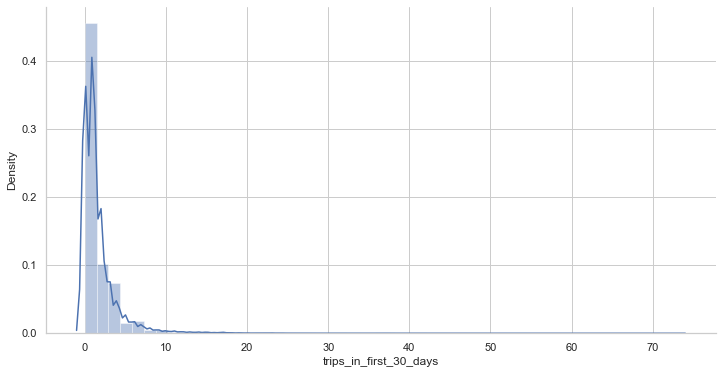

In [31]:
sns.distplot(churn)
sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")
sns.despine()

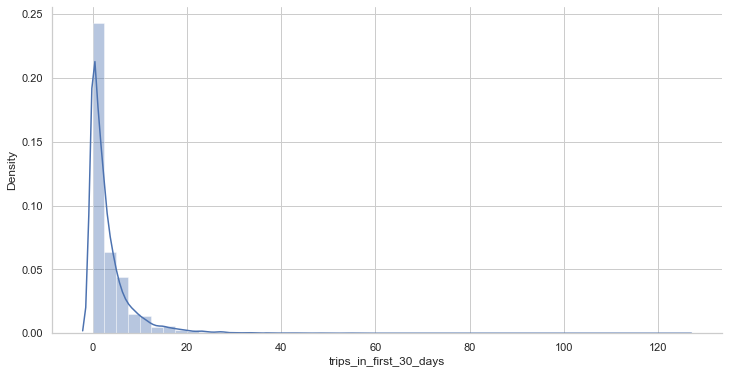

In [32]:
sns.distplot(not_churn)
sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")
sns.despine()

Сравним значения U-тест Манна-Уитни. Тест используется для сравнения различий между двумя выборками, когда распределение выборки не является нормальным.

In [33]:
stats.mannwhitneyu(churn, not_churn).pvalue

0.0

Результат оказался статистически значим, т.к. p-value < 0.05. Значит, ушедшие пользователи были менее активны в первый месяц.

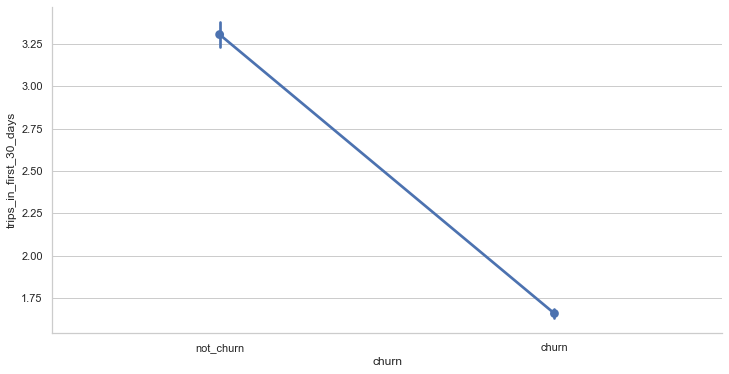

In [34]:
sns.pointplot(x='churn', y='trips_in_first_30_days', data=df)
sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")
sns.despine()